# Marlow Case - TripleTen DS - Sprint 3 Project: #
# Determining the More Profitable Cell Phone Plan #

# Which one is a better plan? #
<a id='intro'></a>

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization
<a id='initial'></a>

In [1]:
# Begin by reading in all the data by importing pandas libraries that I will need.  
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy import stats as st
import seaborn as sns

## Load data

In [2]:
# Load the data files into different DataFrames
filepath = r"C:\Users\marlo\OneDrive\Desktop\Python_Work\Tripleten_Lessons\Sprint_3_Project"

try:
    df_users = pd.read_csv(f"{filepath}\\megaline_users.csv")
except:
    df_users = pd.read_csv('/datasets/megaline_users.csv')

df_users.info()

#notes: The nulls in churn dates are okay. I'm assuming this is a cancellation date, possibly need to remove cancelled users - 
#       But cancelled users usage data is still valid, so will not be removing them. 
#       notably, churn date is an object as well as reg date - will need to fix this

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


First, I want to load in all the data and check the data types; i've confirmed that the columns look good a this point.
        
**Further notes:** 
- users has a churn date == possibly a deletion date, not sure if those users are relevant - I think so. 
- calls has a strange duration format xxx.xx - assuming to be minutes, we will need to round this according to the instructions.
- internet has 0s in mb_used

In [3]:
try:
    df_plans = pd.read_csv(f"{filepath}\\megaline_plans.csv")
except:
    df_plans = pd.read_csv('/datasets/megaline_plans.csv')

df_plans.info()

#notes: this is just descriptive data of the plans. The data looks good, and formats are correct.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
try:
    df_calls = pd.read_csv(f"{filepath}\\megaline_calls.csv")
except:
    df_calls = pd.read_csv('/datasets/megaline_calls.csv')
                       
df_calls.info()

#concerned with the duration column
#according to megaline, seconds are rounded up to minutes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [5]:
try:
    df_internet = pd.read_csv(f"{filepath}\\megaline_internet.csv")
except:
    df_internet = pd.read_csv('/datasets/megaline_internet.csv')

df_internet.info()

#notes:
#according to megaline, mb_used is rounded to the next highest GB, for everything under 2GB (2048 MB) rounds to 2GB for the month
   #will have to aggregate dfs to collect this information, cannot be done in just this single - per session - df
    
#some cells for mb_used are 0, these can be removed as they are not rounded up, and add nothing to the sum.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [6]:
try:
    df_messages = pd.read_csv(f"{filepath}\\megaline_messages.csv")
except:
    df_messages = pd.read_csv('/datasets/megaline_messages.csv')

df_messages.info()

# message_date will need to be converted to datetime - we will need to perform calculations with this date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


## Plans

In [7]:
# Print the general/summary information about the plans' DataFrame
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [8]:
# Print a sample of data for plans
df_plans

messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate

I see no issues with this data. It is just a summary/recap of the plan information.

## Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [9]:
#I am not sure what this is referring to. 

## Users

In [10]:
# Print the general/summary information about the users' DataFrame
df_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [11]:
# Print a sample of data for users
df_users[~df_users['churn_date'].isna()].sample(10, random_state=45)

user_id  first_name last_name  age  \
220     1220        Jack    Strong   26   
441     1441      Piedad     Myers   23   
414     1414  Georgianne   Herring   30   
54      1054       Denis     Frost   50   
180     1180       Wonda      Hays   24   
94      1094      Walter  Petersen   54   
491     1491      Terina    Jensen   22   
83      1083      Lyndia   Acevedo   65   
106     1106        Eddy  Garrison   47   
281     1281        Zack     Hardy   39   

                                          city    reg_date      plan  \
220                   Cincinnati, OH-KY-IN MSA  2018-04-22      surf   
441      Atlanta-Sandy Springs-Roswell, GA MSA  2018-03-08  ultimate   
414                     Urban Honolulu, HI MSA  2018-03-03      surf   
54               Phoenix-Mesa-Chandler, AZ MSA  2018-04-21      surf   
180  New York-Newark-Jersey City, NY-NJ-PA MSA  2018-12-01      surf   
94      Los Angeles-Long Beach-Anaheim, CA MSA  2018-10-30      surf   
491              Grand Rapids-Kentwood, MI MSA  2018-04-27      surf   
83      Los Angeles-Long Beach-Anaheim, CA MSA  2018-10-26      surf   
106  New York-Newark-Jersey City, NY-NJ-PA MSA  2018-05-10      surf   
281      Charlotte-Concord-Gastonia, NC-SC MSA  2018-07-23      surf   

     churn_date  
220  2018-10-13  
441  2018-08-19  
414  2018-09-01  
54   2018-12-31  
180  2018-12-22  
94   2018-12-12  
491  2018-09-18  
83   2018-12-18  
106  2018-11-14  
281  2018-11-14

The date field is showing as an object. Will need to convert this to datetime incase of any calculations with this column. All other columns and data-types look good.  

### Fix Data

In [12]:
# Only concern I am able to see is that the dates are not datetimes, they are objects. I will correct that below
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

#df_users.info()

#If we want to remove the deleted users then use the dataframe below
df_deleted_users = df_users[df_users['churn_date'].notna()]
df_deleted_users

df_active_users = df_users.drop(index=df_deleted_users.index)

#drop the churn column all together, as it is all nulls.
df_active_users = df_active_users.drop('churn_date', axis=1)

df_active_users.info() #34 users removed - correct number

<class 'pandas.core.frame.DataFrame'>
Index: 466 entries, 0 to 499
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     466 non-null    int64         
 1   first_name  466 non-null    object        
 2   last_name   466 non-null    object        
 3   age         466 non-null    int64         
 4   city        466 non-null    object        
 5   reg_date    466 non-null    datetime64[ns]
 6   plan        466 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 29.1+ KB


In [13]:
# check for duplicates
df_user_dups = df_users.duplicated()
print(f"There are {df_user_dups.sum()} duplicate values in the \"users\" data.") #could be showing 0 due to the user_id, 
                                                                                 #same person might have multiple IDs
#check for duplicates based on full name
df_user_dup_names = df_users.duplicated(subset=['first_name', 'last_name'])
print(f"There are {df_user_dup_names.sum()} duplicate names in the \"users\" data.")

There are 0 duplicate values in the "users" data.
There are 0 duplicate names in the "users" data.


I've determined that the users data had object data types for the date fields. I then corrected those, while also leaving all active users in its own variable for safe keeping if needed later (df_active_users). I was also able to determine that there are no duplicate users in the provided users data, I did this by sepcifically checking for unique first and last name pairs, versus all columns, due to the user_id having a chance to be assigned to the same individual multiple times - if this had occurred, I would have removed them.

### Enrich Data

## Calls

In [14]:
# Print the general/summary information about the calls' DataFrame
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [15]:
# Print a sample of data for calls
df_calls.sample(10, random_state=45)

id  user_id   call_date  duration
15332   1061_274     1061  2018-11-16      9.01
96277    1342_25     1342  2018-12-13      4.98
126122  1446_382     1446  2018-12-14      1.09
42503   1156_108     1156  2018-12-04      2.62
104182  1366_391     1366  2018-08-28      0.00
216     1001_396     1001  2018-09-22      0.00
137502  1498_439     1498  2018-05-05      0.00
67190    1241_26     1241  2018-10-10      2.84
81396   1293_354     1293  2018-12-15      0.36
26992   1101_319     1101  2018-05-16     11.52

There are a couple of things to note here. First, and most easily, the call_date column is being read as an object just like the previous date columns - so I will need to correct this by converting it to datetime. Next, I was initially concerned with how to handle the decimals in the duration column, as minutes are not usually represented this way, but I've decided that since Megaline rounds all their seconds up to the nearest minute, it will be a safe procedure to go ahead and round all values up to their closest integer in this column. Lastly, the 0s in the duration column are not useful, as Megaline has told us that the call needs to be one second, and so I will replacing all 0-second calls with 1-second calls. 

In summary: 
1. Correct the date column
2. Convert all instances of "0" to "1" in the duration column
3. Round all remaining calls to the next highest minute value 

### Fix data

In [16]:
# Step 1 - Correct the date column
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format="%Y-%m-%d")
df_calls.head()

id  user_id  call_date  duration
0   1000_93     1000 2018-12-27      8.52
1  1000_145     1000 2018-12-27     13.66
2  1000_247     1000 2018-12-27     14.48
3  1000_309     1000 2018-12-28      5.76
4  1000_380     1000 2018-12-30      4.22

In [17]:
# Step 2 - Convert 0s to 1s
df_calls['duration'] = df_calls['duration'].replace(0, 1)
df_calls.query("duration == 0")

Empty DataFrame
Columns: [id, user_id, call_date, duration]
Index: []

In [18]:
# Step 3 - Round all call durations to the next highest minute value
df_calls['duration'] = df_calls['duration'].apply(math.ceil)
df_calls.sample(10, random_state=10)

id  user_id  call_date  duration
51859    1187_52     1187 2018-12-12        20
123778  1436_785     1436 2018-09-11         4
59688    1215_73     1215 2018-09-26         1
124129  1438_177     1438 2018-11-11         1
53456   1192_229     1192 2018-11-04         1
55919    1201_17     1201 2018-07-29         1
85050    1313_30     1313 2018-06-14         1
32879   1123_237     1123 2018-11-03         1
16147     1064_5     1064 2018-07-17        13
124993  1440_509     1440 2018-08-03         5

<div class="alert alert-block alert-warning">
<b>Reviewer's comment v1</b>
 
Good that you did not forget about data rounding. Also, great choice of `math.ceil` function :)
As a second approach you could also use `np.ceil` here. 

`calls['duration'] = np.ceil(calls['duration'])`

### Enrich data

In [19]:
print(df_calls.duplicated().sum()) #this type of data would be challenging to define duplicate values

0


## Messages

In [20]:
# Print the general/summary information about the messages' DataFrame
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [21]:
# Print a sample of data for messages
df_messages.sample(10)

id  user_id message_date
7593   1059_476     1059   2018-08-17
39636  1257_189     1257   2018-05-11
56326  1355_516     1355   2018-10-23
59556   1379_33     1379   2018-12-03
1894    1019_66     1019   2018-12-25
18343  1120_112     1120   2018-06-04
477    1004_157     1004   2018-05-27
11080  1077_351     1077   2018-06-13
569    1006_127     1006   2018-12-17
34959   1223_49     1223   2018-11-01

Like the other dataframes, the message_date column is reading as an object, I will need to convert this to a datetime. 

### Fix data

In [22]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format="%Y-%m-%d")
#df_messages.info()

### Enrich data

In [23]:
df_messages.duplicated().sum()

0

## Internet

In [24]:
# Print the general/summary information about the internet DataFrame
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [25]:
# Print a sample of data for the internet traffic
df_internet.sample(10, random_state=50)

id  user_id session_date  mb_used
86743   1403_91     1403   2018-04-04   807.32
43491  1193_414     1193   2018-07-09     0.00
84349  1392_317     1392   2018-11-16   325.80
70226  1328_185     1328   2018-12-19   155.08
57837  1261_299     1261   2018-07-26   775.39
67489  1313_163     1313   2018-10-19   288.88
28716   1132_98     1132   2018-06-13     0.00
25665  1120_187     1120   2018-09-07   728.02
92752  1433_136     1433   2018-12-01   378.67
8087   1043_171     1043   2018-11-23   515.70

A common theme that the date column is read as an object, I will need to convert this to datetime. Secondly, unlike the calls data with the duration information, Megaline has informed us that they do their rounding of internet usage at the end of the month, so we will need to perform some aggregation before executing that round, I will not be doing that at this base level. However, the 0 MB used is of no use to me or Megaline, I will remove these.

### Fix data

In [26]:
# Step 1 - Correct the date field. 
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
#df_internet.info()

In [27]:
# Step 2 - Remove the 0s in mb_used
mb_used_nulls = df_internet.query("mb_used == 0")

df_internet = df_internet.drop(index=mb_used_nulls.index)
print(f"""Previously, our internet data contained 104,825 rows of data, and after removing all of the 0 mb sessions, which
contributes nothing to the overall sum, there are {len(df_internet):,} rows of data. 
I have removed {104825 - len(df_internet):,} rows of data.""")

Previously, our internet data contained 104,825 rows of data, and after removing all of the 0 mb sessions, which
contributes nothing to the overall sum, there are 91,078 rows of data. 
I have removed 13,747 rows of data.


### Enrich data

In [28]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


## Study plan conditions

In [29]:
# Print out the plan conditions and make sure they are clear for you
df_plans

messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate

 ***Surf Plan***

1. **Monthly Charge**: $20
2. **Included in the Plan**:
    - 500 monthly minutes
    - 50 texts
    - 15 GB of data

**After exceeding the package limits**:
- Additional 1 minute: 3 cents
- Additional 1 text message: 3 cents
- Additional 1 GB of data: $10

***Ultimate Plan***

1. **Monthly Charge**: $70
2. **Included in the Plan**:
    - 3000 monthly minutes
    - 1000 text messages
    - 30 GB of data

**After exceeding the package limits**:
- Additional 1 minute: 1 cent
- Additional 1 text message: 1 cent
- Additional 1 GB of data: $7


<div class="alert alert-success">
<b>Reviewer's comment v1:</b>
    
Everything is correct here. 

## Aggregate data per user

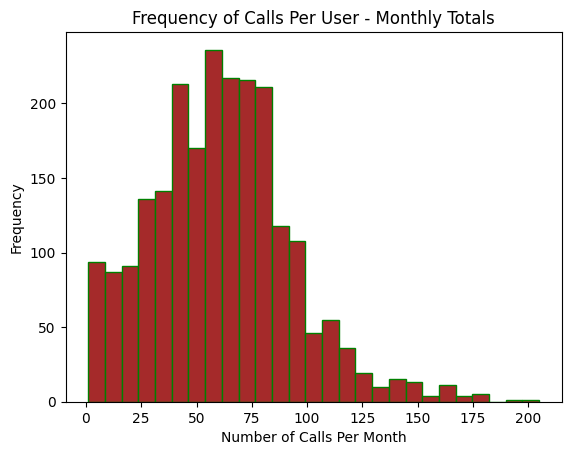

In [30]:
# Calculate the number of calls made by each user per month. Save the result.

# Will begin by making a new month column in order to group by this. 
df_calls['month'] = df_calls['call_date'].dt.month

num_of_calls = df_calls.groupby(['user_id', 'month']).size().reset_index(name='call_count')
#print(num_of_calls)

#can plot this with a histogram
num_of_calls['call_count'].plot(kind='hist',
                                bins=27, #Rice Rule
                                color='brown',
                                edgecolor='green',
                                title="Frequency of Calls Per User - Monthly Totals")

plt.xlabel('Number of Calls Per Month')
plt.show()

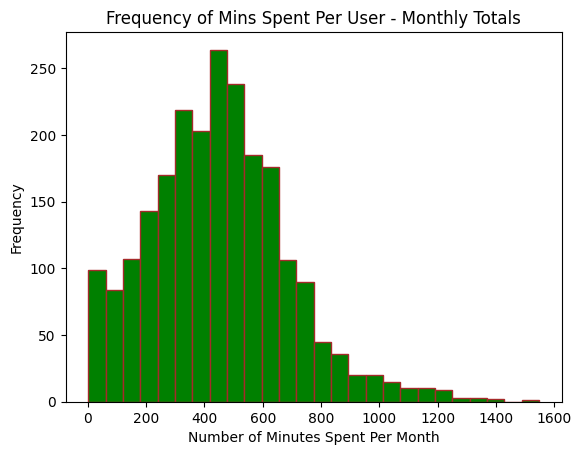

In [31]:
# Calculate the amount of minutes spent by each user per month. Save the result.
mins_spent = df_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index(name='mins_spent')

# Will represent this with a histogram
mins_spent['mins_spent'].plot(kind='hist',
                                bins=26, #Rice Rule
                                color='green',
                                edgecolor='brown',
                                title="Frequency of Mins Spent Per User - Monthly Totals")

plt.xlabel('Number of Minutes Spent Per Month')
plt.show()

<div class="alert alert-warning" role="alert">
<b>Reviewer's comment v1:</b>
    
In pivot_table or groupby it is possible to pass multiple arguments, so here, you can create an aggregated table in one go like this:


```
flattened_calls = calls.groupby(['user_id', 'month']).agg({'duration': ('count', 'sum')}).reset_index()
flattened_calls.columns = ['user_id', 'month', 'count', 'sum']
flattened_calls
```

or 

```
data_calls.pivot_table(index = ('user_id','month'), values = 'duration', aggfunc = ('count','sum')).reset_index()
```

Interesting to note how similar this histogram is to the previous one. It makes sense as well, those making similar amount of calls might spend a similar amount of time on the phone - even though these things are completely independent of each other. More of a coincidence than something that should be expected. 

In [32]:
# Calculate the number of messages sent by each user per month. Save the result.

# To do this per month, I will make a new column that obtains the month data
df_messages['month'] = df_messages['message_date'].dt.month
df_messages.head(5)

# Next create a pivot table displaying all users
num_of_messages = df_messages.pivot_table(index=['user_id', 'month'],
                                          values='id',
                                          aggfunc='count').reset_index()

num_of_messages.columns = ['user_id', 'month', 'message_count']
num_of_messages

user_id  month  message_count
0        1000     12             11
1        1001      8             30
2        1001      9             44
3        1001     10             53
4        1001     11             36
...       ...    ...            ...
1801     1496      9             21
1802     1496     10             18
1803     1496     11             13
1804     1496     12             11
1805     1497     12             50

[1806 rows x 3 columns]

<div class="alert alert-block alert-warning">
<b>Reviewer's comment v1</b>
 
Everything is correct here, but it is always helpful to double-check whether we indeed have data within one year/time period. If not, then selecting and aggregating data by the month number will cause an issue. It is safer to use datetime64[M], which provides a complete date.

Additionally, you could achieve the same using the following code: 
    
```    
calls['call_date'].dt.to_period('M')
```

In [33]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

# Again, to begin I will make a month column from the session_date column
df_internet['month'] = df_internet['session_date'].dt.month
df_internet.head(5)

# Now use a pivot table to display information
internet_volume = df_internet.pivot_table(index=['user_id', 'month'],
                                          values='mb_used',
                                          aggfunc='sum').reset_index()

internet_volume.columns = ['user_id', 'month', 'mb_total']

#note, these are the values that would be rounded up. I can go ahead and do that now. 
internet_volume['mb_total'] = internet_volume['mb_total'].apply(math.ceil)
internet_volume.sample(10, random_state=5) #looks good

user_id  month  mb_total
1013     1212     10     12505
1170     1249     10     11661
954      1198     11     14362
1171     1250     10      8512
1689     1364      9     14819
1152     1246      5     19821
1835     1397      7     24073
2237     1492      9      3174
427      1090      6     15488
1757     1381      9     11831

In [34]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
print(f"internet_volume = {internet_volume.columns}.")
print(f"num_of_messages = {num_of_messages.columns}.")
print(f"mins_spent = {mins_spent.columns}.")
print(f"num_of_calls = {num_of_calls.columns}.")

# Will need to perform a series of merges.

internet_volume = Index(['user_id', 'month', 'mb_total'], dtype='object').
num_of_messages = Index(['user_id', 'month', 'message_count'], dtype='object').
mins_spent = Index(['user_id', 'month', 'mins_spent'], dtype='object').
num_of_calls = Index(['user_id', 'month', 'call_count'], dtype='object').


In [35]:
final_data = pd.merge(internet_volume, num_of_messages, on=['month', 'user_id'], how='inner')
final_data = pd.merge(final_data, mins_spent, on=['month', 'user_id'], how='inner')
final_data = pd.merge(final_data, num_of_calls, on=['month', 'user_id'], how='inner')

final_data.head(10).sort_values(by=['month', 'user_id']) #looks good
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        1759 non-null   int64
 1   month          1759 non-null   int32
 2   mb_total       1759 non-null   int64
 3   message_count  1759 non-null   int64
 4   mins_spent     1759 non-null   int64
 5   call_count     1759 non-null   int64
dtypes: int32(1), int64(5)
memory usage: 75.7 KB


In [36]:
# Add the plan information
df_users_subset = df_users[['user_id', 'plan']]
final_data = pd.merge(final_data, df_users_subset, on='user_id', how='inner')
final_data.head(10).sort_values(by=['month', 'user_id'])

user_id  month  mb_total  message_count  mins_spent  call_count      plan
1     1001      8      6920             30         187          27      surf
2     1001      9     13315             44         326          49      surf
3     1001     10     22331             53         411          65      surf
6     1002     10      6553             15          62          11      surf
4     1001     11     18505             36         441          64      surf
7     1002     11     19346             32         393          55      surf
0     1000     12      1902             11         124          16  ultimate
5     1001     12     19370             44         422          56      surf
8     1002     12     14397             41         393          47      surf
9     1003     12     27045             50        1135         149      surf

<div class="alert alert-danger" role="alert">
<b>Reviewer's comment v1:</b>
    
Here you need to use another way of joining tables (change the how parameter). Now, if users made calls, but did not send messages, it will not be tracked in the new table (the same with the Internet). This will happen because with the left method we take all the keys from the left table and look for their matches in the right table. If there are unique values in the right table, we will ignore them. For this task, we need to take all the records from the right and left tables. You can see about connections here https://www.freecodecamp.org/news/sql-join-types-inner-join-vs-outer-join-example/#:~:text=The biggest difference between an,table in the resulting table.

<div class="alert alert-block alert-info"> <b>Student answer.</b> <a class="tocSkip"></a> 
I switched to an outer join. Since this opens our data columns up to null values, is there a way to deal with the float type, or is that practical and acceptable?</div>

<div class="alert alert-success">
<b>Reviewer's comment v2:</b>

Indeed `how=outer` is a correct way of keeping all data. 

In [37]:
# for reference if needed
ultimate_data = final_data.query("plan == 'ultimate'")
surf_data = final_data.query("plan == 'surf'")
print(ultimate_data.head())
print(surf_data.head())

    user_id  month  mb_total  message_count  mins_spent  call_count      plan
0      1000     12      1902             11         124          16  ultimate
19     1006     11      2069             15          10           2  ultimate
20     1006     12     32119            139          61           9  ultimate
26     1008     10     17107             21         493          71  ultimate
27     1008     11     23677             37         459          63  ultimate
   user_id  month  mb_total  message_count  mins_spent  call_count  plan
1     1001      8      6920             30         187          27  surf
2     1001      9     13315             44         326          49  surf
3     1001     10     22331             53         411          65  surf
4     1001     11     18505             36         441          64  surf
5     1001     12     19370             44         422          56  surf


In [38]:
# Calculate the monthly revenue for each user

def revenue(month_user):
    #begin with surf
    if month_user['plan'] == 'surf':
        base_charge = 20
        additional_mins   = max(month_user['mins_spent'] - 500, 0)   #ensures that all values below 500 have 0 additional mins
        additional_texts  = max(month_user['message_count'] - 50, 0)
        additional_gigs   = max(month_user['mb_total'] - 15000, 0) / 1024   #divide by 1024 to convert to GB
        additional_charge = (0.03)*(additional_mins) + (0.03)*(additional_texts) + (10)*(additional_gigs)
    elif month_user['plan'] == 'ultimate':
        base_charge = 50
        additional_mins   = max(month_user['mins_spent'] - 500, 0)
        additional_texts  = max(month_user['message_count'] - 50, 0)
        additional_gigs   = max(month_user['mb_total'] - 15000, 0) / 1024   
        additional_charge = (0.01)*(additional_mins) + (0.01)*(additional_texts) + (7)*(additional_gigs)
    else:
        print(f"ALERT! THIS USER {row['user_id']} IS CHEATING THE SYSTEM!") #shouldn't ever happen, fun code
        
    total_charge = round(additional_charge + base_charge, 2)
    
    return total_charge

<div class="alert alert-warning">
<b>Reviewer's comment v1:</b>

One minor remark is that you need to divide by 1024 to get GB.

<div class="alert alert-block alert-info"> <b>Student answer.</b> <a class="tocSkip"></a> 
Corrected. Thank you! I don't know why I was thinking it was 1000. </div>

<div class="alert alert-success">
<b>Reviewer's comment v2:</b>

👏 Eventually it all depends on the conversion system we choose. You can check it here: https://future-hacker.medium.com/1gb-1000mb-or-1024mb-what-is-right-there-is-some-twist-95cebeb436ec

In [39]:
# Now add this data to the data-frame
final_data['monthly_revenue'] = final_data.apply(revenue, axis=1)

ultimate_data = final_data.query("plan == 'ultimate'")
surf_data = final_data.query("plan == 'surf'")

ult_sum = ultimate_data['monthly_revenue'].sum()
surf_sum = surf_data['monthly_revenue'].sum()

print(f"The total revenue for the Ultimate Plan is {ult_sum:,}.")
print(f"The total revenue for the Surf Plan is {surf_sum:,}.")

final_data.head(10)

The total revenue for the Ultimate Plan is 45,669.8.
The total revenue for the Surf Plan is 70,336.29000000001.


user_id  month  mb_total  message_count  mins_spent  call_count      plan  \
0     1000     12      1902             11         124          16  ultimate   
1     1001      8      6920             30         187          27      surf   
2     1001      9     13315             44         326          49      surf   
3     1001     10     22331             53         411          65      surf   
4     1001     11     18505             36         441          64      surf   
5     1001     12     19370             44         422          56      surf   
6     1002     10      6553             15          62          11      surf   
7     1002     11     19346             32         393          55      surf   
8     1002     12     14397             41         393          47      surf   
9     1003     12     27045             50        1135         149      surf   

   monthly_revenue  
0            50.00  
1            20.00  
2            20.00  
3            91.68  
4            54.23  
5            62.68  
6            20.00  
7            62.44  
8            20.00  
9           156.68

Surf plan users are punished more for using a subscription they pay for, it makes sense that the total revenue for this plan is higher - mostly also due to the fact that there are more Surf users than Ultimate as far as the totals go. Megaline could probably increase the punishment values slightly and none would be the wiser ==>> more money.


In [40]:
#Remove outliers - expecting they will need to be removed and want to save code
#final_data.sort_values(by='mb_total').tail(2)
#final_data.sort_values(by='message_count').tail(2)
#final_data = final_data.drop(index=[856, 1377, 1383, 139])


<div class="alert alert-success" role="alert">
<b>Reviewer's comment v1:</b>

Everything is correct here. 

Btw it is also possible to make the calculation of revenue a little bit shorter / easier using np.where - https://numpy.org/doc/stable/reference/generated/numpy.where.html
    
```
np.where ('condition: if exceeding the package limit', 'multiply the difference by the price of additional services', '0')
```

    
Great thing about python is that there are so many libraries and ready-to-use functions. For example, this task can also be solved using `.clip()` (a useful method in many tasks). You can read it here: https://www.pythonpool.com/numpy-clip/
    
Also, it is better to avoid hard-coding in your functions of all values from the data plans. These values could be frequently updated and it will be annoyingly inconvenient to update them once again in the function. I would recommend using an actual table with values or create a separate data dictionary - https://towardsdatascience.com/12-examples-to-master-python-dictionaries-5a8bcd688c6d

## Study user behaviour

### Calls

In [41]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plot to visualize it.
# To do this I will group the data by plan and month, then calculate the average call duration

# First need to add plan to df_calls
df_calls = pd.merge(df_calls, df_users_subset, on='user_id', how='inner')

#Use a pivot table
avg_call_duration = df_calls.pivot_table(index=['plan', 'month'],
                                         values='duration',
                                         aggfunc='mean').reset_index()

avg_call_duration.columns=['plan', 'month', 'avg_call_length']
avg_call_duration['avg_call_length'] = round(avg_call_duration['avg_call_length'], 2)
avg_call_duration

plan  month  avg_call_length
0       surf      1             6.97
1       surf      2             7.49
2       surf      3             7.29
3       surf      4             7.38
4       surf      5             7.37
5       surf      6             7.44
6       surf      7             7.32
7       surf      8             7.32
8       surf      9             7.32
9       surf     10             7.32
10      surf     11             7.35
11      surf     12             7.43
12  ultimate      1             7.15
13  ultimate      2             7.11
14  ultimate      3             6.82
15  ultimate      4             7.27
16  ultimate      5             7.26
17  ultimate      6             7.30
18  ultimate      7             7.47
19  ultimate      8             7.22
20  ultimate      9             7.37
21  ultimate     10             7.27
22  ultimate     11             7.34
23  ultimate     12             7.27

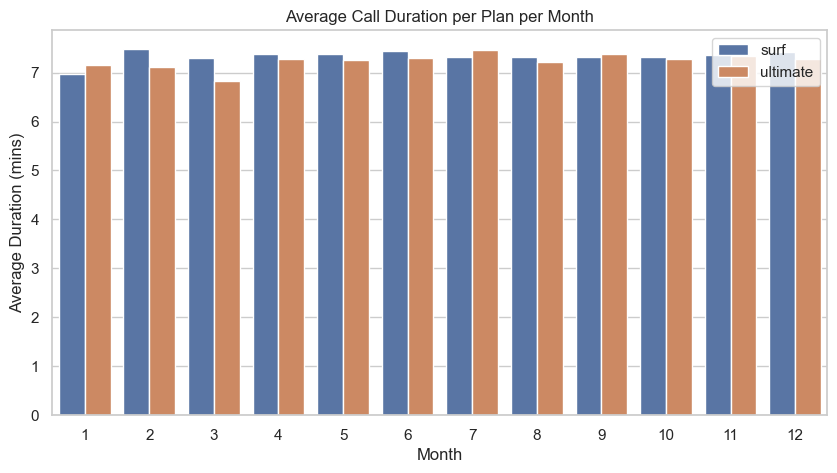

In [42]:
# Plot a bar plot
plt.figure(figsize=(10, 5))

sns.set(style="whitegrid")

sns.barplot(data=avg_call_duration, x='month', y='avg_call_length', hue='plan')

plt.title('Average Call Duration per Plan per Month')
plt.xlabel('Month')
plt.ylabel('Average Duration (mins)')
plt.legend()

plt.show()

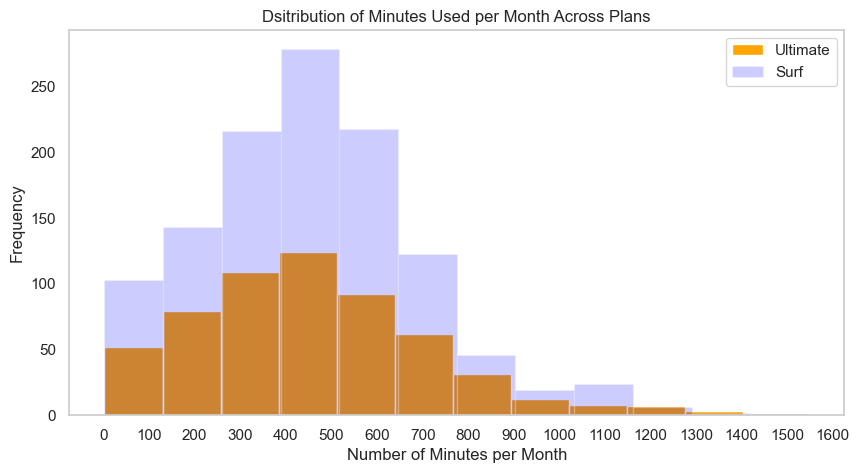

In [43]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
plt.figure(figsize=(10,5))

#Sturge's Rule applied to both - since datasets aren't large
ultimate_data['mins_spent'].plot(kind='hist', bins = 11, label='Ultimate', color='orange')
surf_data['mins_spent'].plot(kind='hist', bins = 12, label='Surf', color='blue', alpha=0.2)  


#create even labels at intervals of 100 for x-axis (cause I wanted to)
xtics= []
for i in range(1601):
    if i % 100 == 0:
        xtics.append(i)

plt.xlabel('Number of Minutes per Month')
plt.title('Dsitribution of Minutes Used per Month Across Plans')
plt.legend()
plt.xticks(xtics)
plt.grid(False)

plt.show()

In [44]:
# Calculate the mean and the variance of the monthly call duration
ult_mean = ultimate_data['mins_spent'].mean()
surf_mean = surf_data['mins_spent'].mean()

ult_sigma = ultimate_data['mins_spent'].var()
surf_sigma = surf_data['mins_spent'].var()

print(f"The means of the call duration per month for Ultimate plan users is {ult_mean:.2f}, and is {surf_mean:.2f} for Surf plan users.")
print(f"The variance of the call duration per month for Ultimate plan users is {ult_sigma:,.2f}, and is {surf_sigma:,.2f} for Surf plan users.\n")
print("Both plans have a high variance, or dispersion from the mean, which indicates to me significant variability in call durations; however, the Ultimate plan users are more variable. So far, the plans do not appear to differ in a meaningful/significant way.")

The means of the call duration per month for Ultimate plan users is 454.81, and is 457.83 for Surf plan users.
The variance of the call duration per month for Ultimate plan users is 65,557.50, and is 58,102.83 for Surf plan users.

Both plans have a high variance, or dispersion from the mean, which indicates to me significant variability in call durations; however, the Ultimate plan users are more variable. So far, the plans do not appear to differ in a meaningful/significant way.


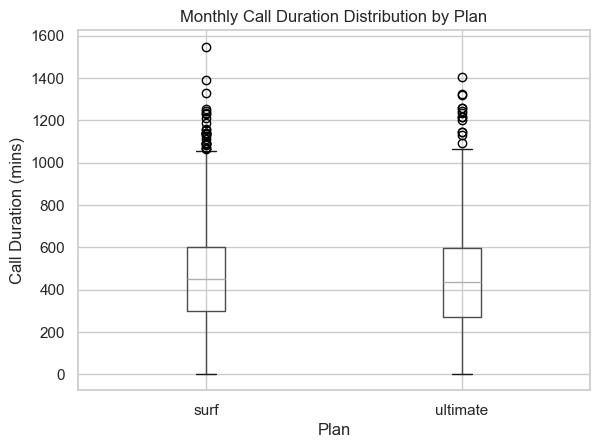

In [45]:
# Plot a boxplot to visualize the distribution of the monthly call duration
final_data.boxplot(column='mins_spent', by='plan')

plt.title('Monthly Call Duration Distribution by Plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Call Duration (mins)')
plt.show()

This boxplot helps paint a clearer picture of the call duration distributions for the Ultimate and Surf plans. We can see that the distributions are actually quite simlar with some minor differences. 
    
**Median and Shape:** Medians appear to be relatively the same, as well as the shape of both plans - both being skewed right. This indicates that most users tend to have lower call durations, but some users have significantly highers call durations. 
    
**Variance and Outliers:** Where the plans start to differ, and where the box plot is helpful, is putting a visual to the variance and outliers. We can see there are more extreme values in the Surf plan users' call durations, emphasizing that the spread from the mean is greater than the Ultimate plan. The Ultimate plan distribution also follows the same patterns, just to a lesser degree. The key is is we can see there is greater spread in the Surf plan call durations than in the Ultimate. 

<div class="alert alert-warning">
<b>Reviewer's comment v1:</b>
    
To avoid repetitive code you could utilize functions. 

### Messages

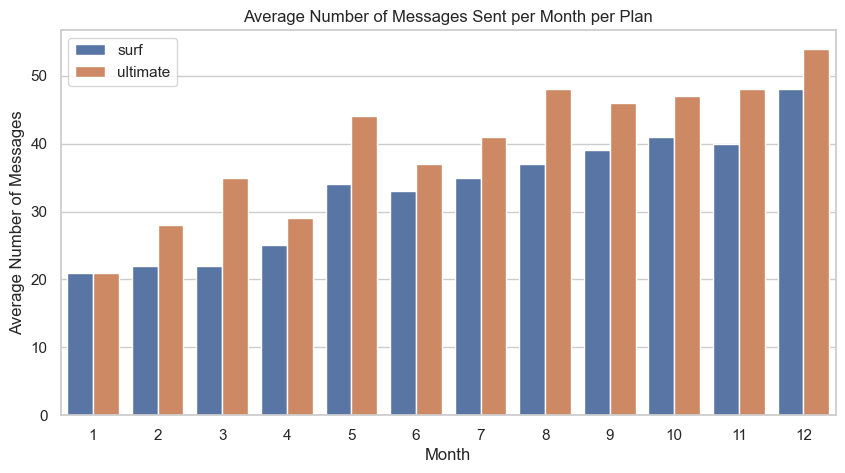

In [46]:
# I will follow same formula laid out above for the rest of the categories. 
# I will compare the average amount of messages sent per month, per plan

avg_msg_sent = final_data.pivot_table(index=['plan','month'],
                                       values='message_count',
                                       aggfunc='mean').reset_index()


avg_msg_sent.columns=['plan','month','avg_msgs_sent']
avg_msg_sent['avg_msgs_sent'] = round(avg_msg_sent['avg_msgs_sent']).astype('int')
avg_msg_sent

# Begin Bar Plot
plt.figure(figsize=(10,5))

sns.barplot(data=avg_msg_sent, x='month', y='avg_msgs_sent', hue='plan')

plt.title('Average Number of Messages Sent per Month per Plan')
plt.xlabel('Month')
plt.ylabel('Average Number of Messages')
plt.legend()

plt.show()

One pattern is quite clear looking at the average number of messages sent per plan each month: that the average number of messages sent appears to have a positive correlation to the month. We can't really make any conclusions on causation, but we can take some guesses on why this would be the case. Perhaps the holiday seasons create more text messages, or perhaps we are gaining more users as the year goes on. We would want to look at other years to be sure. 

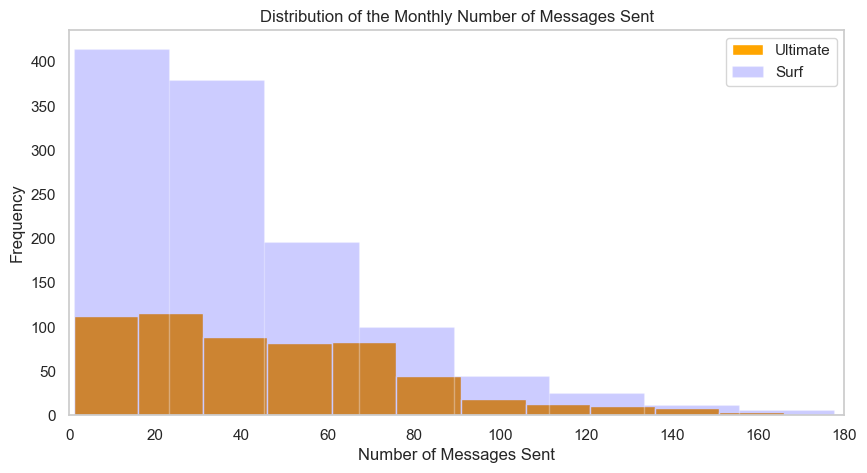

In [47]:
# Next I will compare the number of messages sent via a histogram
plt.figure(figsize=(10,5))

ultimate_data['message_count'].plot(kind='hist', bins=11, label='Ultimate', color='orange')
surf_data['message_count'].plot(kind='hist', bins=12
                                , label='Surf', color='blue', alpha=0.2) 

plt.title('Distribution of the Monthly Number of Messages Sent')
plt.xlabel('Number of Messages Sent')
plt.xlim(0,180)
plt.legend()
plt.grid(False)

plt.show()

This actually makes a lot of sense. For the Surf users, they are charged more for going over on messages, so most of them are sending lower amounts of messages. Whereas the Ultimate users have more cushion, and we see almost a uniform distribution until the higher numbers. Interesting!

In [48]:
# Next I will calculate the mean and variance
ult_msg_mean = ultimate_data['message_count'].mean()
surf_msg_mean = surf_data['message_count'].mean()

ult_msg_sigma = ultimate_data['message_count'].var()
surf_msg_sigma = surf_data['message_count'].var()

print(f"The means of the number of messages per month for Ultimate plan users is {ult_msg_mean:.0f}, and is {surf_msg_mean:.0f} for Surf plan users.")
print(f"The variance of the number of messages per month for Ultimate plan users is {ult_msg_sigma:.2f}, and is {surf_msg_sigma:.2f} for Surf plan users.\n")

The means of the number of messages per month for Ultimate plan users is 46, and is 39 for Surf plan users.
The variance of the number of messages per month for Ultimate plan users is 1084.39, and is 1044.22 for Surf plan users.



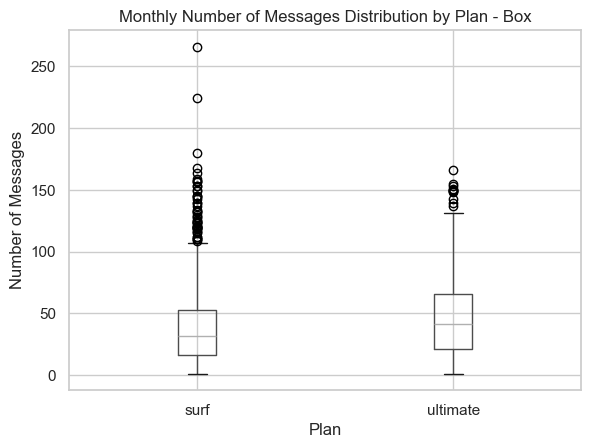

In [49]:
final_data.boxplot(column='message_count', by='plan')

plt.title('Monthly Number of Messages Distribution by Plan - Box')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Number of Messages')
plt.show()

Both plans have similar variances, with the Ultimate users being slightly greater, indicating a slightly larger spread. As I had mentioned earlier, what's interesting is there does appear to be a difference in their distributions, and consequently their behavior.

**Shape:** Whether it is statistically significant is still unclear, but we can see that the distributions have a different shape, between Surf and Ultimate. The Surf users have a smaller amount of allowed texts, so we can see a greater skew in the distribution as most users are remaining within those guidelines, with quite a few going outside of it. In the Ultimate distribution, we do see an almost uniform like distribution, likely this is due to the greater amount of texts allowed. 

**Outliers:** I would like to point out the considerable number of extreme values that exist in the Surf distribution. Perhaps some of these users should save some money and switch to the ultimate plan, but of course we don't mind if they stay at the surf level!

**Conclusion:** Due to the almost uniform nature of the ultimate distribution versus the highly right-skewed surf distribution, I would say that Ultimate users are sending more messages. The frequency is not a comparison point, there are more surf users. It would be interesting to see how the Ultimate distribution shape changes as we acquire more customers. 


### Internet

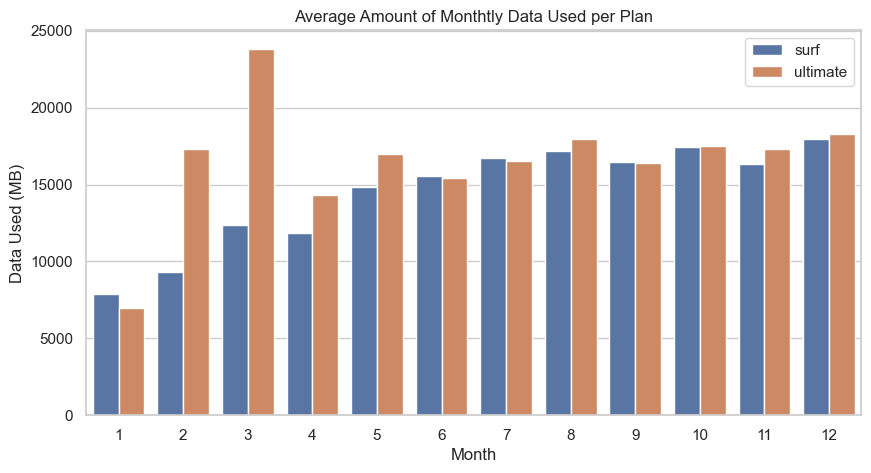

In [50]:
avg_data_used = final_data.pivot_table(index=['plan','month'],
                                       values='mb_total',
                                       aggfunc='mean').reset_index()

avg_data_used.columns =['plan','month','avg_mb_used']
avg_data_used['avg_mb_used'] = (round(avg_data_used['avg_mb_used'])).astype('int')
avg_data_used

# Begin bar plot
plt.figure(figsize=(10,5))

sns.barplot(data=avg_data_used, x='month', y='avg_mb_used', hue='plan')

plt.title('Average Amount of Monthtly Data Used per Plan')
plt.xlabel('Month')
plt.ylabel('Data Used (MB)')
plt.legend()

plt.show()

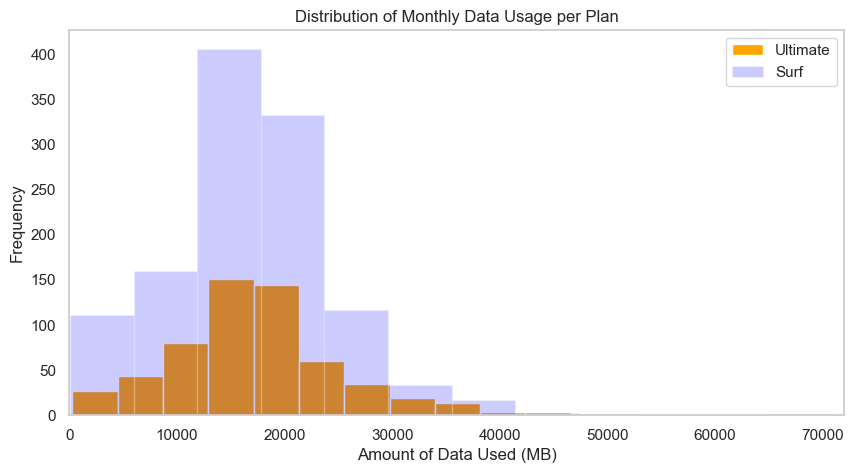

In [51]:
plt.figure(figsize=(10,5))

ultimate_data['mb_total'].plot(kind='hist', bins=11, label='Ultimate', color='orange')
surf_data['mb_total'].plot(kind='hist', bins=12, label='Surf', color='blue', alpha=0.2)

plt.title('Distribution of Monthly Data Usage per Plan')
plt.xlabel('Amount of Data Used (MB)')
plt.legend()
plt.xlim(0,72000)
plt.grid(False)
plt.show()

In [52]:
ult_mbs_mean = ultimate_data['mb_total'].mean()
surf_mbs_mean = surf_data['mb_total'].mean()

ult_mbs_sigma = ultimate_data['mb_total'].var()
surf_mbs_sigma = surf_data['mb_total'].var()

print(f"The means of the number of messages per month for Ultimate plan users is {ult_mbs_mean:,.0f}, and is {surf_mbs_mean:,.0f} for Surf plan users.")
print(f"The variance of the number of messages per month for Ultimate plan users is {ult_mbs_sigma:,.2f}, and is {surf_mbs_sigma:,.2f} for Surf plan users.")

The means of the number of messages per month for Ultimate plan users is 17,251, and is 16,630 for Surf plan users.
The variance of the number of messages per month for Ultimate plan users is 59,090,306.33, and is 59,510,087.75 for Surf plan users.


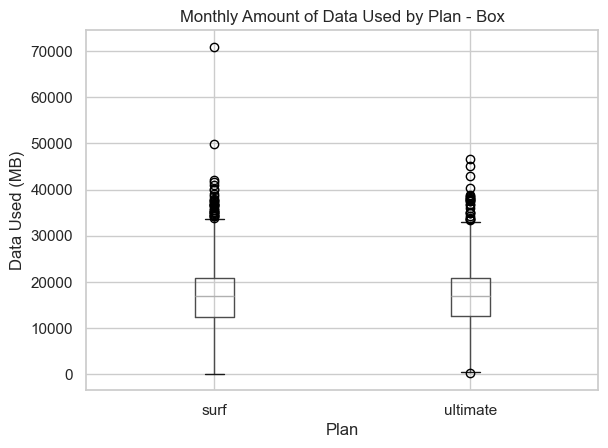

In [53]:
final_data.boxplot(column='mb_total', by='plan')

plt.title('Monthly Amount of Data Used by Plan - Box')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Data Used (MB)')
plt.show()

Looking at all of the graphics and data, there doesn't appear to be a distinctional difference in behavior between the two plans when it comes to the amount of data used per month. There are however some interesting points left to still make. 

**Shape and Outliers:** When looking at the shapes of each graphical distribution it may appear there are some significant differences due to the size for the surf bars in the average plot for months 2 and 3, this is most definitely due to the extreme values which are more clearly represented in the box plot. There are two values in particular that are significantly farter into the outlier region than the others (those users certainly had a big bill that month). I would imagine we would want to remove these values, as they do not appear to be usual. The nice bell-curve pattern is interesting. 

**Conclusion:** I do not believe there is a difference in behavior in the amount of data used across users between the two plans.

## Revenue

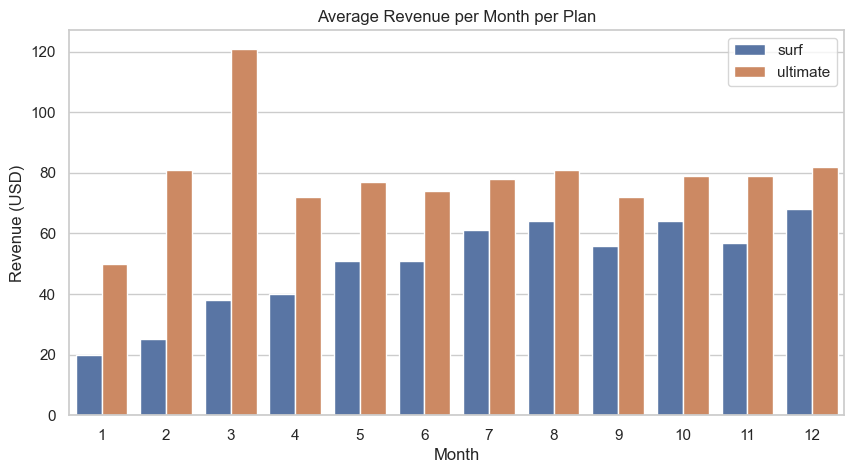

In [54]:
avg_data_used = final_data.pivot_table(index=['plan','month'],
                                       values='monthly_revenue',
                                       aggfunc='mean').reset_index()

avg_data_used.columns =['plan','month','avg_mb_used']
avg_data_used['avg_mb_used'] = (round(avg_data_used['avg_mb_used'])).astype('int')
avg_data_used

# Begin bar plot
plt.figure(figsize=(10,5))

sns.barplot(data=avg_data_used, x='month', y='avg_mb_used', hue='plan')

plt.title('Average Revenue per Month per Plan')
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.legend()

plt.show()

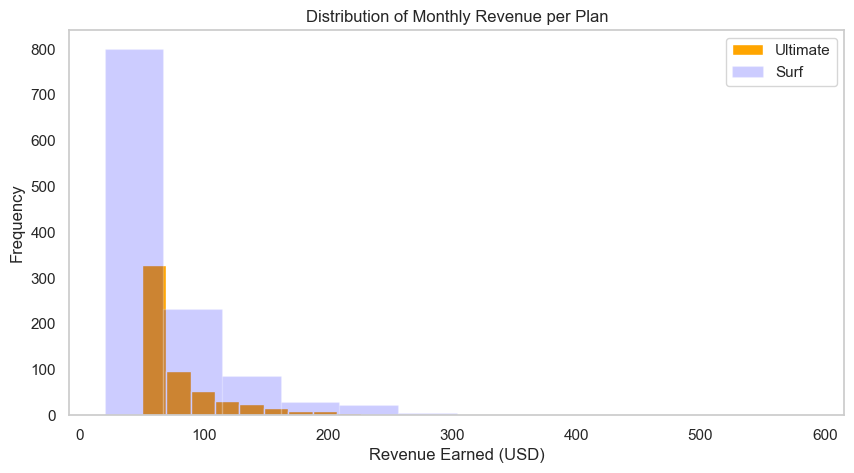

In [55]:
plt.figure(figsize=(10,5))

ultimate_data['monthly_revenue'].plot(kind='hist', bins=11, label='Ultimate', color='orange')
surf_data['monthly_revenue'].plot(kind='hist', bins=12, label='Surf', color='blue', alpha=0.2)

plt.title('Distribution of Monthly Revenue per Plan')
plt.xlabel('Revenue Earned (USD)')
plt.legend()
plt.grid(False)
plt.show()

In [56]:
ult_rev_mean = ultimate_data['monthly_revenue'].mean()
surf_rev_mean = surf_data['monthly_revenue'].mean()

ult_rev_sigma = ultimate_data['monthly_revenue'].var()
surf_rev_sigma = surf_data['monthly_revenue'].var()

print(f"The means of the revenue per month for Ultimate plan users is ${ult_rev_mean:,.2f}, and is ${surf_rev_mean:,.2f} for Surf plan users.")
print(f"The variance of the revenue per month for Ultimate plan users is ${ult_rev_sigma:,.2f}, and is ${surf_rev_sigma:,.2f} for Surf plan users.")

The means of the revenue per month for Ultimate plan users is $78.88, and is $59.61 for Surf plan users.
The variance of the revenue per month for Ultimate plan users is $1,547.83, and is $2,814.34 for Surf plan users.


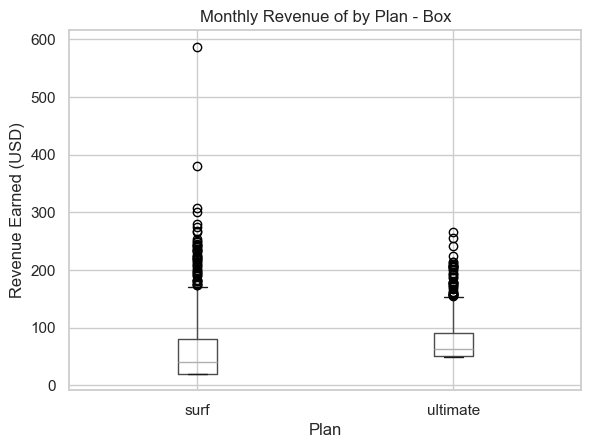

In [57]:
final_data.boxplot(column='monthly_revenue', by='plan')

plt.title('Monthly Revenue of by Plan - Box')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Revenue Earned (USD)')
plt.show()

I would have to say that there is a pretty clear winner in terms of which plan would bring in more revenue for Megaline, and that's the Ultimate plan, however we could manipulate the surf plan to take advantage of the high variability we have found.

As stated earlier, if we have more users on the surf plan and we slightly adjust our punishment values, we should be able to create more outliers like seen in the box plot, while also shifting the median average revenue up, which means more money in Megaline's pocket and still happy customers. Aggressively increasing those punishment values will cause us to lose clientell, and we don't want that to happen. So I would recommend to slightly increase the punishment values on the Surf plan. 

However, based on the graphics above, we can clearly see that the Ultimate plan would generate more revenue on average per user. So the next step for Megaline is to adjust marketing to either bring in new Ultimate plan users, or convert Surf users over to Ultimate (maybe a special few month discount for switching? Sometimes I'm not just an analyst). 

<div class="alert alert-success">
<b>Reviewer's comment v1:</b>
    
- I will write overall thoughts about the data analysis section:
- Very nice visualisation of the data. Great that you combined both plans on one graph for the comparison and also used different graph types to check available data.
-  If you have time and willing to practice, you can display two charts (histogram and a boxplot) using a two-column subplot.

```
    # Create one row with 2 columns
	  fig, axes = plt.subplots(1, 2, figsize=(16, 5))

	  # Create a histogram for the surf plan
	  sns.distplot(... ax=axes[0])
	  # Create a histogram for the second plan
	  sns.distplot(... ax=axes[0])
	
	  # Create a boxplot for both plans
	  sns.boxplot(... ax=axes[1])
```

## Test statistical hypotheses

In [58]:
# Test the hypotheses
# Let Mu_ru be the mean of the revenue for Ultimate users
# Let Mu_rs be the mean of the revenue for the Surf users

# H0: Mu_ru = Mu_rs
# H1: Mu_ru <> Mu_rs
#Conduct a two tailed t-test: requirements are independent groups, normally distributed (just skewed), sample size is good

# Begin test
alpha = 0.05

results = st.ttest_ind(ultimate_data['monthly_revenue'], surf_data['monthly_revenue'], equal_var=False)

print(f"p-value: {results.pvalue:.30f}")

if results.pvalue < alpha:
    print("We reject the null hypothesis that the average revenue from users of the Ultimate and Surf calling plans are equal.")
else:
    print("We can't reject the null hypothesis that the average revenue from users of the Ultimate and Surf calling plans are equal.")

p-value: 0.000000000000000025908446580958
We reject the null hypothesis that the average revenue from users of the Ultimate and Surf calling plans are equal.


[Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.]

In [59]:
# Test the hypotheses
# Let Mu_NY be the mean of the revenue for users in the NY-NJ area
# Let Mu_XNYX be the mean of the revenye for users not in the NY-NJ area

# H0: Mu_NY = Mu_XNYX
# H1: Mu_NY <> Mu_XNYX
# Conduct a two tailed t-test: requirements stated above, they are met. 

#Before I begin, I will need to add the city information
df_city = df_users[['user_id', 'city']]

final_data = pd.merge(final_data, df_city, on='user_id', how='inner')
final_data.head() #looks good

user_id  month  mb_total  message_count  mins_spent  call_count      plan  \
0     1000     12      1902             11         124          16  ultimate   
1     1001      8      6920             30         187          27      surf   
2     1001      9     13315             44         326          49      surf   
3     1001     10     22331             53         411          65      surf   
4     1001     11     18505             36         441          64      surf   

   monthly_revenue                                   city  
0            50.00  Atlanta-Sandy Springs-Roswell, GA MSA  
1            20.00        Seattle-Tacoma-Bellevue, WA MSA  
2            20.00        Seattle-Tacoma-Bellevue, WA MSA  
3            91.68        Seattle-Tacoma-Bellevue, WA MSA  
4            54.23        Seattle-Tacoma-Bellevue, WA MSA

In [60]:
ny_data = final_data[final_data['city'].str.contains('NY')]
other_regions = final_data[~final_data['city'].str.contains('NY')]


In [61]:
# Begin Test
alpha = 0.05

result = st.ttest_ind(ny_data['monthly_revenue'], other_regions['monthly_revenue'], equal_var=True)

print(f"p-value: {result.pvalue}")

if result.pvalue < alpha:
    print("We reject the null hypothesis that the average revenue from users in the NY-NJ area and other regions are equal.")
else:
    print("We can't reject the null hypothesis that the average revenue from users in the NY-NJ area and other regions are equal.")

p-value: 0.1811771711512009
We can't reject the null hypothesis that the average revenue from users in the NY-NJ area and other regions are equal.


## Conclusion

After a thorough analysis of user behavior and revenue generation across Megaline's Surf and Ultimate plans, several key insights have emerged. 

1. **User Behavior**: While both plans exhibit similar trends in call duration and internet usage, there was one major difference and a couple nuanced differences. The major difference being in the behavior when sending text messages. The data corresponded to Surf plan users sending more messages across the board, even so that we saw a difference in their distribution shapes, although minor. Surf plan users also tend to have higher variability in call duration, message count, and internet usage; potentially this is due to the plan's lower allotments. Meanwhile, Ultimate plan users demonstrated some more uniform behavior, likely influenced by their higher plan limits.

2. **Revenue Generation**: Ultimate plan users contribute more to Megaline's revenue on average compared to Surf plan users. Despite the higher monthly fee, the Ultimate plan's payment structer and lesser variability, but still a high variability, in behavior contribute to its higher revenue. However, there's an opportunity to strategically adjust the Surf plan's penalty charges to capitalize on its higher variability and potentially increase revenue while keeping clients subscribed.

3. **Marketing Strategy**: Based on the revenue analysis, Megaline can consider adjusting its marketing strategy to target new customers for the Ultimate plan or encourage Surf plan users to switch. Special promotions or incentives for plan switches could be effective strategies to achieve this.

4. **Statistical Significance**: Statistical tests infer that the average revenue from users on the Ultimate and Surf plans is different. Additionally, we tested the hypothesis that the average revenue from users in the NY-NJ region is the same as the average revenue from users in other regions while assuming the variances for these two popluations are equal, and we were unable to reject this hypothesis.

In conclusion, Megaline now has valuable insights into user behavior and revenue generation that can inform strategic decisions to optimize marketing efforts, plan offerings, and ultimately drive an increase in business growth. I wish them the best of luck!
